In [2]:
#data analysis and wranding
import numpy as np
import pandas as pd
import random as rnd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb

# change style
sns.set()

# データインポート、結合、columns拡大
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# データ削除時のための対応
train_df["TrainFlag"] = True
test_df["TrainFlag"] = False

data = pd.concat([train_df, test_df], sort=False)

# expand the number of displayed columns
pd.set_option('display.max_columns', 151)

In [9]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainFlag
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True


## 欠損値確認

In [10]:
# check the missing data 1
data.info()
print('_'*40)
data.info()

# check the missing data 2(Understanding the numerical features)
data.describe()

# check the missing data 3
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  TrainFlag    1309 non-null   bool   
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 134.2+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
--

,Total,Percent
Cabin,1014,0.774637
Survived,418,0.319328
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000


## 特徴量確認

### Numerical features

countやmax, meanに注目

In [11]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## categorical features

countに注目

In [12]:
data.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


Correlating

各特徴が生存率とどの程度相関しているかを知りたい。これはプロジェクトの初期に行い、これらの迅速な相関をプロジェクトの後半でモデル化された相関とマッチングさせたい。

欠損値補完
1. Ageは生存率と深くかかわっており、補完したい。
2. Embarkedも同様に生存率と深くかかわっており、補完したい。

修正
1. Ticketはuniqueが多く、生存率とも関係がないため消去したい。
2. Cabinは欠損データが多いため、削除したい。
3. Nameは生存率と直接は関わっていないだろうから、削除したい。

特徴量生成

1. ParchとSibSpを基にFamilyという新しい特徴量を作成し、搭乗している家族の総数を取得したいかもしれない。
2. 特徴量から「役職」フィーチャーを作成するかもしれない。
3. 年齢帯を表す新しい分類をを作成する。これは、連続的な数値素性を順序的なカテゴリ素性に変換するものである。
4. ま分析に役立つのであれば、Fare range 特徴量を作成するのもよいでしょう。

分類

また、先に述べた問題の説明に基づいて、仮定を追加することもできます。

1. 女性(Sex=female)の方が生存している可能性が高い。
2. 子供(Age<?)の方が生存している可能性が高い。
3. 上流階級の乗客(Pclass=1)の方が生存していた可能性が高い。

In [13]:
# カラムの確認
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TrainFlag'],
      dtype='object')

#### Pclassが小さいほど生存率が高い　　→PClassを特徴量に載せる

In [14]:
train_df[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by = "Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### 男の方が生存率が高い　→男女を特徴量に載せる

In [15]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by = "Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [16]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [17]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


<AxesSubplot:xlabel='Familysize', ylabel='count'>

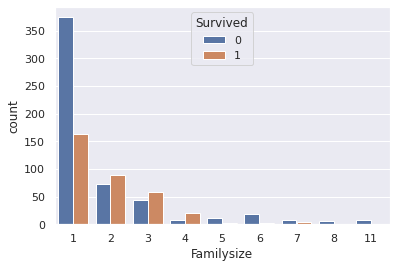

In [4]:
data["Familysize"] = data["Parch"] + data["SibSp"] + 1
train_df["Familysize"] = train_df["Parch"] + train_df["SibSp"] + 1
test_df["Familysize"] = test_df["Parch"] + test_df["SibSp"] + 1

sns.countplot(x="Familysize", data=train_df, hue="Survived")

ここでFamilySize >= 5の場合、死亡が生存を上回っており、生存率が低いことが分かる。

‣ Survived == 0: 死亡

‣ dot Survived == 1: 生存

「一緒に乗船した家族の人数が多い方が、生存率が低そうだ」という（ぼんやりとした）仮説が、可視化を通じて「FamilySize >= 5の場合、生存率が低いので、この特徴量は予測精度に寄与しそうだ」という確信を持った仮説に変わった。

更に今回、可視化を通じて、それまで持っていなかった仮説（情報）を得ることもできました。「FamilySize == 1」の人が圧倒的に多く、かつ生存率が低いということです。

この「FamilySize == 1」であるという特徴量も予測精度に寄与しそうなので、下記のように新しく「IsAlone」という特徴量を作成してみましょう。

In [5]:
data["IsAlone"] = 0
data.loc[data["Familysize"] == 1, "IsAlone"] = 1

#train_df['IsAlone'] = data['IsAlone'][:len(train_df)]
#test_df['IsAlone'] = data['IsAlone'][len(train_df):]
train_df['IsAlone'] = data.loc[data["TrainFlag"] == True]['IsAlone']
test_df['IsAlone'] = data.loc[data["TrainFlag"] == False]['IsAlone']

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


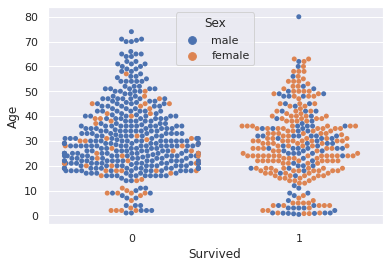

In [20]:
#bivariate analysis saleprice/grlivarea
var = 'Age'
#data = pd.concat([train_df['Survived'], df_train[var]], axis=1)
sns.swarmplot(x="Survived", y=var, data=train_df, hue="Sex");

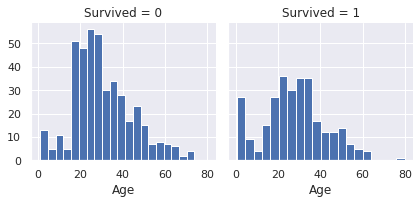

In [21]:
g = sns.FacetGrid(data=train_df, col="Survived")
g.map(plt.hist, "Age", bins=20)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


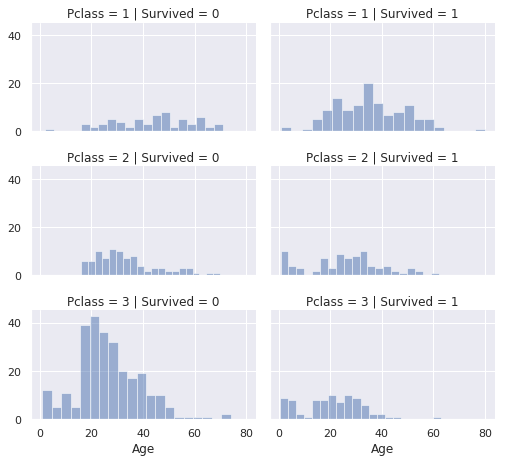

In [22]:
grid = sns.FacetGrid(data=train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


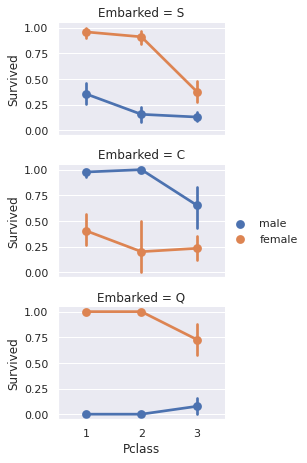

In [23]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


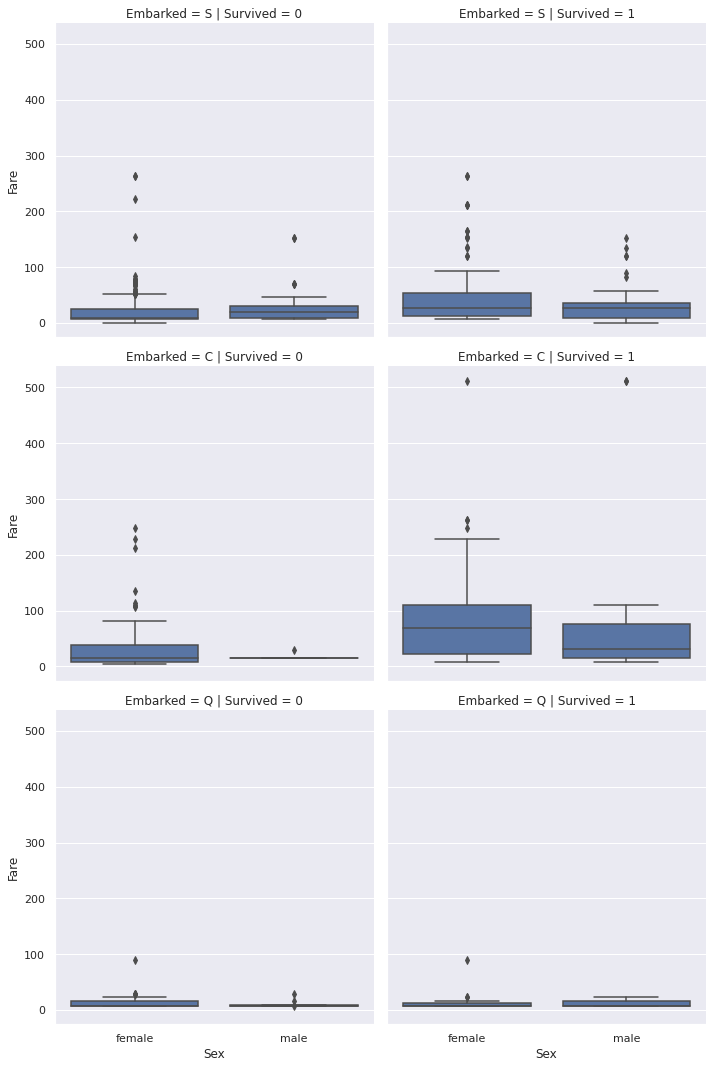

In [24]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=5, aspect=1)
grid.map(sns.boxplot, 'Sex', 'Fare')
grid.add_legend()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 48.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Survived', ylabel='Fare'>

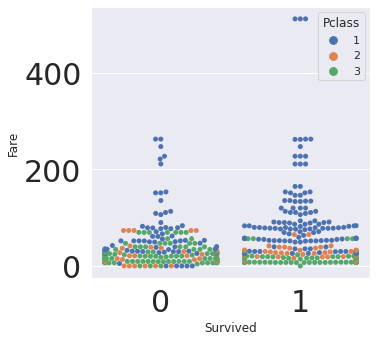

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.tick_params(labelsize=30)
# axesオブジェクトを引数に入れる
sns.swarmplot(ax=ax, x='Survived', y='Fare', data=train_df, hue="Pclass")

In [8]:
# fillout null
data["Sex"] = data["Sex"].replace(["male", "female"], [0, 1])
freq_port = data["Embarked"].dropna().mode()[0]
data["Embarked"] = data["Embarked"].fillna(freq_port)
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
data["Fare"] = data["Fare"].fillna(data["Fare"].dropna().median())
data["Age"] = data["Age"].fillna(data["Age"].dropna().median())

# データ削除
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data = data.drop(delete_columns, axis=1)


# データ分割
train_df = data[data["TrainFlag"] == True]
test_df = data[data["TrainFlag"] == False]

# traindata　生成
y_train = train_df['Survived']
X_train = train_df.drop(['Survived', 'TrainFlag'], axis=1)
X_test = test_df.drop(['Survived', 'TrainFlag'], axis=1)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [9]:
y_train = train_df['Survived']
X_train = train_df.drop(['Survived', 'TrainFlag'], axis=1)
X_test = test_df.drop(['Survived', 'TrainFlag'], axis=1)

In [33]:
print(X_train.columns, X_test.columns)

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'IsAlone'], dtype='object') Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'IsAlone'], dtype='object')


0.8417508417508418
0.7171615090075952


<AxesSubplot:>

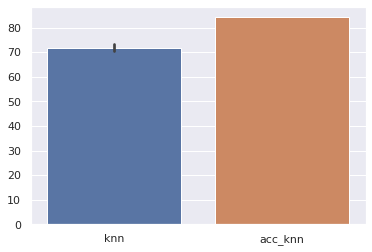

In [28]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print(knn.score(X_train, y_train))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
kn_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(kn_scores.mean())
score_df = pd.DataFrame({'knn': kn_scores *100, "acc_knn": acc_knn})
sns.barplot(data=score_df)

In [29]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
decisiontree_scores = cross_val_score(decision_tree, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(decisiontree_scores.mean())

0.7897453601991925


0.8140522670683993


<AxesSubplot:>

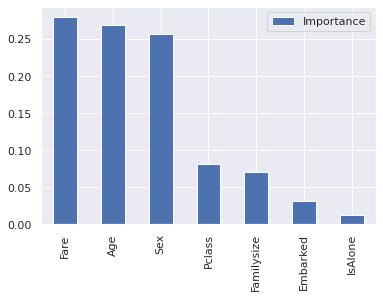

In [30]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_s = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
rdmforest_scores = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(rdmforest_scores.mean())

# Visualize the importance of each feature
importances = random_forest.feature_importances_
feature_importances = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances.plot.bar()

In [31]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
svc_scores = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(svc_scores.mean())

0.6752725294499194


In [ ]:
# models = pd.DataFrame({
#    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
#              'Random Forest', 'Naive Bayes', 'Perceptron', 
#              'Stochastic Gradient Decent', 'Linear SVC', 
#              'Decision Tree'],
#    'Score': [acc_svc, acc_knn, acc_log, 
#              acc_random_forest, acc_gaussian, acc_perceptron, 
#              acc_sgd, acc_linear_svc, acc_decision_tree]})
# models.sort_values(by='Score', ascending=False)

In [ ]:
model = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

#eval_set = [(X_test, y_test)]
#callbacks = []
#callbacks.append(lgb.early_stopping(stopping_rounds=10))
#callbacks.append(lgb.log_evaluation())
#model.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)
X_train_re = X_train.drop("IsAlone", axis = 1)
X_test_re = X_test.drop("IsAlone", axis = 1)
model.fit(X_train_re, y_train)
y_pred_lbg = model.predict(X_test_re)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
model_scores = cross_val_score(model, X_train_re, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(model_scores.mean())
lgb.plot_importance(model)
#metrics.log_loss(y_test, y_pred)

In [38]:
# Random Forestで提出
sub = gender_submission
sub['Survived'] = list(map(int, y_pred_lbg))
sub.to_csv("submission.csv", index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
